# Cross Validation

Este notebook apresenta técnicas de validação cruzada para avaliação robusta de modelos.


In [1]:
# Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Configuração de plotting
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)

## Objetivos da Aula

- K-Fold e Stratified K-Fold
- Leave-One-Out Cross-Validation
- Comparação de modelos com CV
- Escolha do número de folds


Dataset criado:
- Número de amostras: 1000
- Número de features: 2
- Distribuição de classes: [501 499]


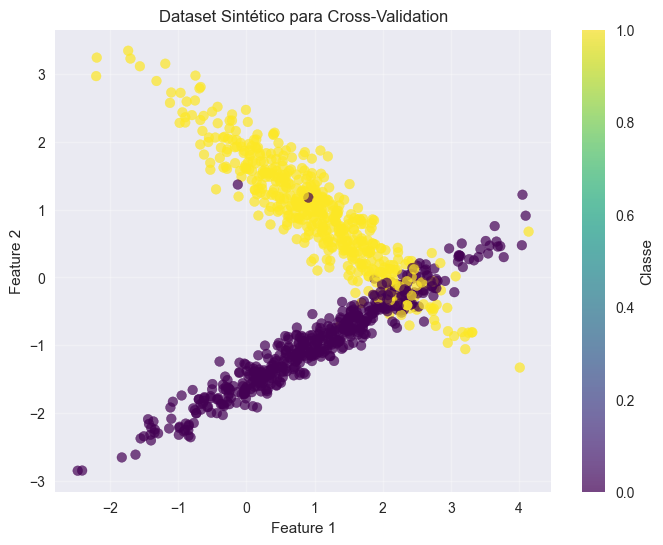

In [2]:
# Criação de dataset sintético para demonstração
X, y = make_classification(
    n_samples=1000, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42
)

print(f"Dataset criado:")
print(f"- Número de amostras: {X.shape[0]}")
print(f"- Número de features: {X.shape[1]}")
print(f"- Distribuição de classes: {np.bincount(y)}")

# Visualização inicial do dataset
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7, cmap="viridis")
plt.title("Dataset Sintético para Cross-Validation")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter, label="Classe")
plt.grid(True, alpha=0.3)
plt.show()

## 1. Cross-Validation: Conceitos Fundamentais

A **validação cruzada** (cross-validation) é uma técnica para avaliar modelos de forma mais robusta que o simples holdout validation.

### O Problema do Holdout

- Dependente de uma divisão específica dos dados
- Pode ser instável com datasets pequenos
- Não aproveita todos os dados para treino

### A Solução: Cross-Validation

O CV divide os dados em k subconjuntos (folds) e treina k modelos diferentes:

$$CV_k = \frac{1}{k} \sum_{i=1}^k L(f^{(i)}, \mathcal{D}_i)$$

**Vantagens:**

- Usa todos os dados para treino e validação
- Estimativa mais robusta (múltiplas medições)
- Melhor detecção de overfitting


## 2. Tipos de Cross-Validation

### K-Fold Cross-Validation

- Divide dados em k partes iguais
- Cada amostra é usada uma vez para validação
- Típicamente k=5 ou k=10

### Stratified K-Fold

- Preserva a proporção de classes em cada fold
- **Essencial para datasets desbalanceados**
- Reduz variância da estimativa

### Leave-One-Out (LOOCV)

- Caso extremo: k = n (número de amostras)
- Máximo uso dos dados para treino
- Computacionalmente caro


In [3]:
# Exemplo básico de K-Fold Cross-Validation
from sklearn.model_selection import cross_val_score, cross_validate, KFold

# Criando um classificador
clf = DecisionTreeClassifier(random_state=42, max_depth=5)

# K-Fold com k=5
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation básico
cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring="accuracy")

print("=== K-Fold Cross-Validation (k=5) ===")
print(f"Scores por fold: {cv_scores}")
print(f"Média: {cv_scores.mean():.4f}")
print(f"Desvio padrão: {cv_scores.std():.4f}")

# Múltiplas métricas
scoring = ["accuracy", "precision", "recall", "f1"]
cv_results = cross_validate(clf, X, y, cv=kfold, scoring=scoring, return_train_score=True)

print("\n=== Múltiplas Métricas ===")
for metric in scoring:
    test_scores = cv_results[f"test_{metric}"]
    train_scores = cv_results[f"train_{metric}"]
    print(f"{metric.capitalize()}:")
    print(f"  Teste: {test_scores.mean():.4f} ± {test_scores.std():.4f}")
    print(f"  Treino: {train_scores.mean():.4f} ± {train_scores.std():.4f}")

# Detectando overfitting
accuracy_gap = cv_results["train_accuracy"].mean() - cv_results["test_accuracy"].mean()
print(f"\nGap treino-teste (accuracy): {accuracy_gap:.4f}")
if accuracy_gap > 0.05:
    print("⚠️  Possível overfitting detectado")
else:
    print("✅ Modelo bem generalizado")

=== K-Fold Cross-Validation (k=5) ===
Scores por fold: [0.915 0.93  0.94  0.93  0.915]
Média: 0.9260
Desvio padrão: 0.0097

=== Múltiplas Métricas ===
Accuracy:
  Teste: 0.9260 ± 0.0097
  Treino: 0.9630 ± 0.0040
Precision:
  Teste: 0.9490 ± 0.0239
  Treino: 0.9911 ± 0.0061
Recall:
  Teste: 0.8994 ± 0.0248
  Treino: 0.9343 ± 0.0125
F1:
  Teste: 0.9231 ± 0.0143
  Treino: 0.9618 ± 0.0047

Gap treino-teste (accuracy): 0.0370
✅ Modelo bem generalizado


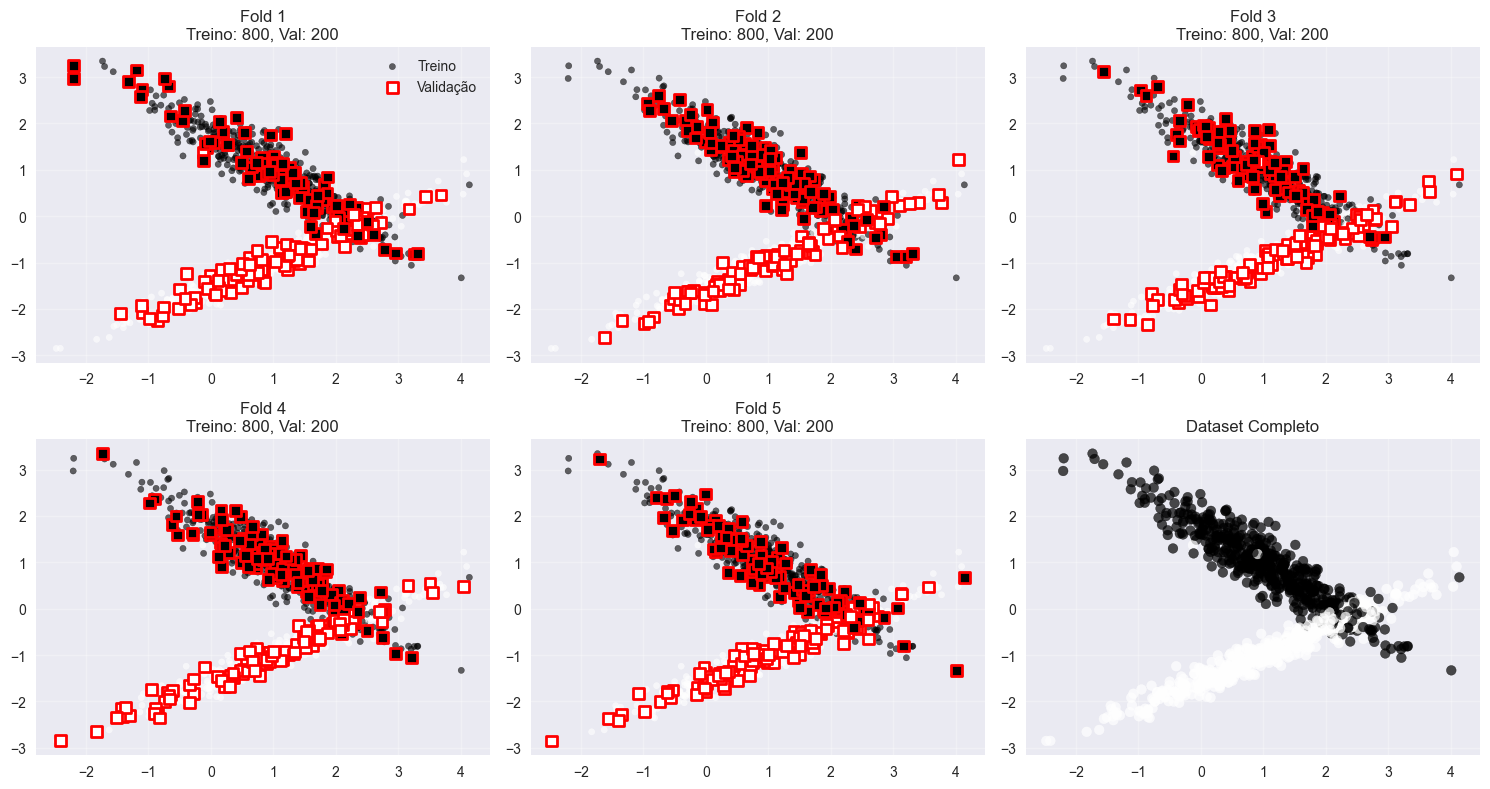

💡 Cada fold usa ~80% para treino e ~20% para validação


In [4]:
# Visualizando as divisões do K-Fold
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

kfold_vis = KFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(kfold_vis.split(X)):
    if i >= 5:
        break

    ax = axes[i]

    # Dados de treino
    ax.scatter(X[train_idx, 0], X[train_idx, 1], c=y[train_idx], alpha=0.6, s=20, label="Treino")

    # Dados de validação (destacados)
    ax.scatter(
        X[val_idx, 0],
        X[val_idx, 1],
        c=y[val_idx],
        alpha=1.0,
        s=60,
        marker="s",
        edgecolor="red",
        linewidth=2,
        label="Validação",
    )

    ax.set_title(f"Fold {i+1}\nTreino: {len(train_idx)}, Val: {len(val_idx)}")
    ax.grid(True, alpha=0.3)

    if i == 0:
        ax.legend()

# Dataset completo
axes[5].scatter(X[:, 0], X[:, 1], c=y, alpha=0.7)
axes[5].set_title("Dataset Completo")
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Cada fold usa ~80% para treino e ~20% para validação")

## 3. Stratified K-Fold vs K-Fold Regular

O Stratified K-Fold é essencial para datasets desbalanceados, garantindo que cada fold mantenha a proporção original das classes.


In [5]:
# Demonstração com dataset desbalanceado
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold

# Dataset desbalanceado (90% classe 0, 10% classe 1)
X_imbal, y_imbal = make_classification(
    n_samples=1000, n_features=2, n_redundant=0, n_informative=2, weights=[0.9, 0.1], random_state=42
)

print("Dataset Desbalanceado:")
print(f"Distribuição: {np.bincount(y_imbal)}")
print(f"Proporção: Classe 0: {(y_imbal==0).mean():.1%}, Classe 1: {(y_imbal==1).mean():.1%}")

# Comparando K-Fold regular vs Stratified
kfold_regular = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n=== Distribuição de Classes por Fold ===")

print("\nK-Fold Regular:")
for i, (_, val_idx) in enumerate(kfold_regular.split(X_imbal)):
    val_dist = np.bincount(y_imbal[val_idx])
    total = len(val_idx)
    prop_0 = val_dist[0] / total if len(val_dist) > 0 else 0
    prop_1 = val_dist[1] / total if len(val_dist) > 1 else 0
    print(f"Fold {i+1}: Classe 0: {prop_0:.1%}, Classe 1: {prop_1:.1%}")

print("\nStratified K-Fold:")
for i, (_, val_idx) in enumerate(kfold_stratified.split(X_imbal, y_imbal)):
    val_dist = np.bincount(y_imbal[val_idx])
    total = len(val_idx)
    prop_0 = val_dist[0] / total
    prop_1 = val_dist[1] / total
    print(f"Fold {i+1}: Classe 0: {prop_0:.1%}, Classe 1: {prop_1:.1%}")

# Comparando performance
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)

cv_regular = cross_val_score(rf_clf, X_imbal, y_imbal, cv=kfold_regular, scoring="f1")
cv_stratified = cross_val_score(rf_clf, X_imbal, y_imbal, cv=kfold_stratified, scoring="f1")

print(f"\n=== Comparação de Performance (F1-Score) ===")
print(f"K-Fold Regular: {cv_regular.mean():.4f} ± {cv_regular.std():.4f}")
print(f"Stratified K-Fold: {cv_stratified.mean():.4f} ± {cv_stratified.std():.4f}")
print(f"Redução na variância: {((cv_regular.std() - cv_stratified.std()) / cv_regular.std() * 100):.1f}%")

Dataset Desbalanceado:
Distribuição: [894 106]
Proporção: Classe 0: 89.4%, Classe 1: 10.6%

=== Distribuição de Classes por Fold ===

K-Fold Regular:
Fold 1: Classe 0: 91.0%, Classe 1: 9.0%
Fold 2: Classe 0: 88.5%, Classe 1: 11.5%
Fold 3: Classe 0: 89.5%, Classe 1: 10.5%
Fold 4: Classe 0: 89.5%, Classe 1: 10.5%
Fold 5: Classe 0: 88.5%, Classe 1: 11.5%

Stratified K-Fold:
Fold 1: Classe 0: 89.5%, Classe 1: 10.5%
Fold 2: Classe 0: 89.5%, Classe 1: 10.5%
Fold 3: Classe 0: 89.5%, Classe 1: 10.5%
Fold 4: Classe 0: 89.5%, Classe 1: 10.5%
Fold 5: Classe 0: 89.0%, Classe 1: 11.0%

=== Comparação de Performance (F1-Score) ===
K-Fold Regular: 0.7917 ± 0.1082
Stratified K-Fold: 0.8290 ± 0.0300
Redução na variância: 72.3%


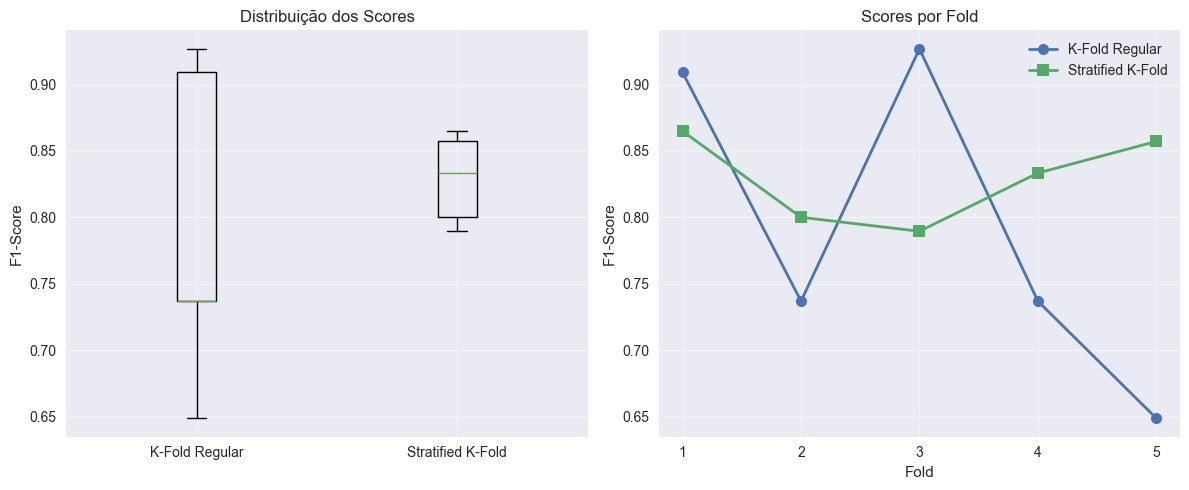

💡 Stratified K-Fold reduz variância e é mais estável


In [6]:
# Visualização comparativa
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot([cv_regular, cv_stratified], tick_labels=["K-Fold Regular", "Stratified K-Fold"])
plt.ylabel("F1-Score")
plt.title("Distribuição dos Scores")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
folds = range(1, 6)
plt.plot(folds, cv_regular, "o-", label="K-Fold Regular", linewidth=2, markersize=8)
plt.plot(folds, cv_stratified, "s-", label="Stratified K-Fold", linewidth=2, markersize=8)
plt.xlabel("Fold")
plt.ylabel("F1-Score")
plt.title("Scores por Fold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(folds)

plt.tight_layout()
plt.show()

print("💡 Stratified K-Fold reduz variância e é mais estável")

## 4. Leave-One-Out Cross-Validation (LOOCV)

LOOCV é um caso extremo onde k = n. Cada iteração usa apenas uma amostra para validação.


In [7]:
# Comparação LOOCV vs K-Fold
from sklearn.model_selection import LeaveOneOut
import time

# Subset menor para demonstração (LOOCV é computacionalmente caro)
X_small = X[:100]
y_small = y[:100]

loocv = LeaveOneOut()
kfold_5 = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_10 = KFold(n_splits=10, shuffle=True, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)

print(f"=== Comparação: LOOCV vs K-Fold ({len(X_small)} amostras) ===")

# LOOCV
start_time = time.time()
loocv_scores = cross_val_score(clf, X_small, y_small, cv=loocv, scoring="accuracy")
loocv_time = time.time() - start_time

print(f"\nLeave-One-Out CV:")
print(f"Folds: {len(loocv_scores)}")
print(f"Média: {loocv_scores.mean():.4f}")
print(f"Std: {loocv_scores.std():.4f}")
print(f"Tempo: {loocv_time:.2f}s")

# 5-Fold CV
start_time = time.time()
kfold5_scores = cross_val_score(clf, X_small, y_small, cv=kfold_5, scoring="accuracy")
kfold5_time = time.time() - start_time

print(f"\n5-Fold CV:")
print(f"Folds: {len(kfold5_scores)}")
print(f"Média: {kfold5_scores.mean():.4f}")
print(f"Std: {kfold5_scores.std():.4f}")
print(f"Tempo: {kfold5_time:.2f}s")

# 10-Fold CV
start_time = time.time()
kfold10_scores = cross_val_score(clf, X_small, y_small, cv=kfold_10, scoring="accuracy")
kfold10_time = time.time() - start_time

print(f"\n10-Fold CV:")
print(f"Folds: {len(kfold10_scores)}")
print(f"Média: {kfold10_scores.mean():.4f}")
print(f"Std: {kfold10_scores.std():.4f}")
print(f"Tempo: {kfold10_time:.2f}s")

print(f"\n=== Eficiência ===")
print(f"LOOCV é {loocv_time/kfold5_time:.1f}x mais lento que 5-Fold")
print(f"LOOCV é {loocv_time/kfold10_time:.1f}x mais lento que 10-Fold")

print(f"\n💡 LOOCV: máximo uso dos dados, mas computacionalmente caro")

=== Comparação: LOOCV vs K-Fold (100 amostras) ===

Leave-One-Out CV:
Folds: 100
Média: 0.8300
Std: 0.3756
Tempo: 0.12s

5-Fold CV:
Folds: 5
Média: 0.8400
Std: 0.0735
Tempo: 0.01s

10-Fold CV:
Folds: 10
Média: 0.8300
Std: 0.1005
Tempo: 0.01s

=== Eficiência ===
LOOCV é 19.4x mais lento que 5-Fold
LOOCV é 10.7x mais lento que 10-Fold

💡 LOOCV: máximo uso dos dados, mas computacionalmente caro


## 5. Escolha do Número de Folds

A escolha de k afeta tanto a qualidade da estimativa quanto o custo computacional.


=== Análise do Número de Folds ===
k= 3: 0.9340 ± 0.0048, 0.15s
k= 5: 0.9400 ± 0.0122, 0.27s
k= 7: 0.9360 ± 0.0222, 0.39s
k=10: 0.9360 ± 0.0211, 0.58s
k=15: 0.9380 ± 0.0345, 0.87s
k=20: 0.9360 ± 0.0383, 1.19s


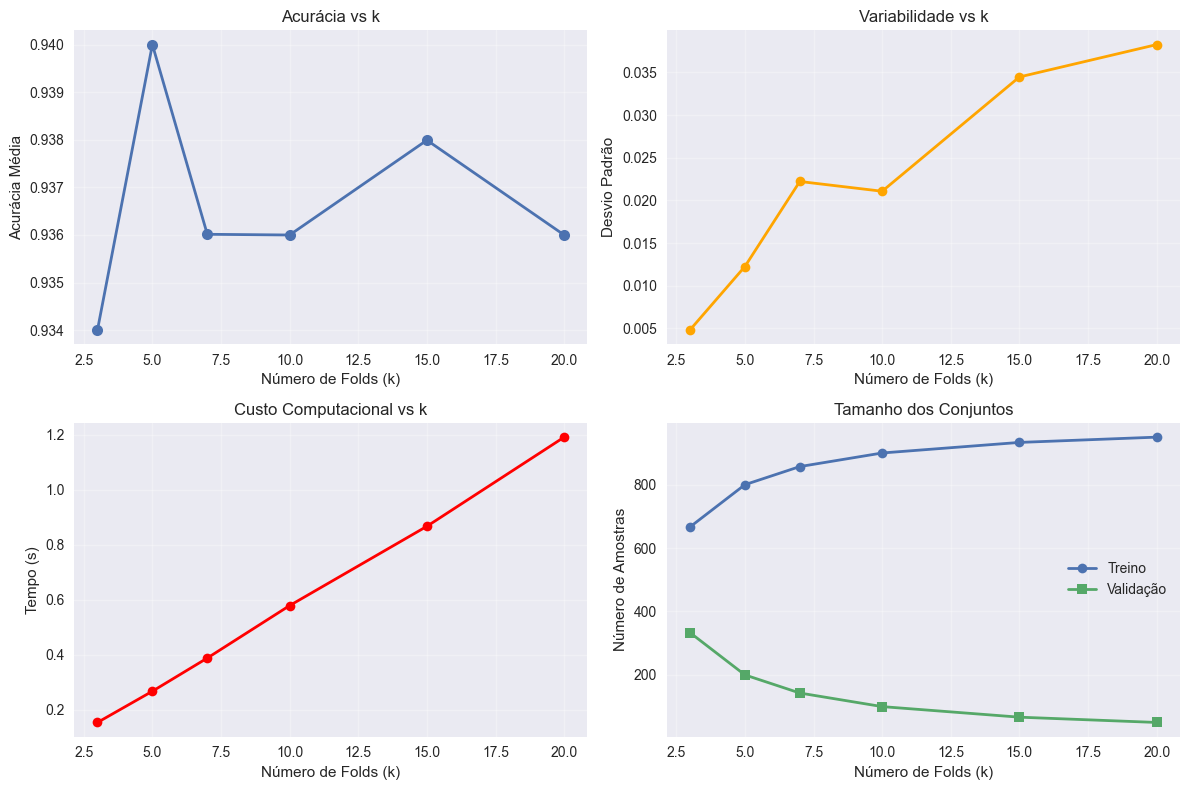


=== Recomendações ===
• k=5: Boa opção geral, rápido
• k=10: Padrão na literatura
• k>10: Para datasets pequenos


In [8]:
# Análise do impacto do número de folds
k_values = [3, 5, 7, 10, 15, 20]
results_summary = []

clf = RandomForestClassifier(n_estimators=50, random_state=42)

print("=== Análise do Número de Folds ===")

for k in k_values:
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    start_time = time.time()
    cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring="accuracy")
    execution_time = time.time() - start_time

    results_summary.append(
        {
            "k": k,
            "mean_accuracy": cv_scores.mean(),
            "std_accuracy": cv_scores.std(),
            "execution_time": execution_time,
            "train_size": len(X) * (k - 1) / k,
            "val_size": len(X) / k,
        }
    )

    print(f"k={k:2d}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}, {execution_time:.2f}s")

results_df = pd.DataFrame(results_summary)

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Acurácia vs k
axes[0, 0].plot(results_df["k"], results_df["mean_accuracy"], "o-", linewidth=2, markersize=8)
axes[0, 0].set_xlabel("Número de Folds (k)")
axes[0, 0].set_ylabel("Acurácia Média")
axes[0, 0].set_title("Acurácia vs k")
axes[0, 0].grid(True, alpha=0.3)

# Variabilidade vs k
axes[0, 1].plot(results_df["k"], results_df["std_accuracy"], "o-", color="orange", linewidth=2)
axes[0, 1].set_xlabel("Número de Folds (k)")
axes[0, 1].set_ylabel("Desvio Padrão")
axes[0, 1].set_title("Variabilidade vs k")
axes[0, 1].grid(True, alpha=0.3)

# Tempo vs k
axes[1, 0].plot(results_df["k"], results_df["execution_time"], "o-", color="red", linewidth=2)
axes[1, 0].set_xlabel("Número de Folds (k)")
axes[1, 0].set_ylabel("Tempo (s)")
axes[1, 0].set_title("Custo Computacional vs k")
axes[1, 0].grid(True, alpha=0.3)

# Tamanho dos conjuntos
axes[1, 1].plot(results_df["k"], results_df["train_size"], "o-", label="Treino", linewidth=2)
axes[1, 1].plot(results_df["k"], results_df["val_size"], "s-", label="Validação", linewidth=2)
axes[1, 1].set_xlabel("Número de Folds (k)")
axes[1, 1].set_ylabel("Número de Amostras")
axes[1, 1].set_title("Tamanho dos Conjuntos")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Recomendações ===")
print("• k=5: Boa opção geral, rápido")
print("• k=10: Padrão na literatura")
print("• k>10: Para datasets pequenos")

## 6. Comparação de Modelos com Cross-Validation

CV é ideal para comparar diferentes algoritmos de forma justa.


In [9]:
# Criando dataset sintético para comparação de modelos
from sklearn.preprocessing import StandardScaler

# Dataset mais complexo
X_complex, y_complex = make_classification(
    n_samples=1000, n_features=10, n_informative=7, n_redundant=3, n_classes=2, weights=[0.6, 0.4], random_state=42
)

# Normalizando features
scaler = StandardScaler()
X_complex_scaled = scaler.fit_transform(X_complex)

print("=== Dataset para Comparação ===")
print(f"Shape: {X_complex_scaled.shape}")
print(f"Classes: {np.bincount(y_complex)}")
print(f"Proporção: {(y_complex==0).mean():.1%} / {(y_complex==1).mean():.1%}")

=== Dataset para Comparação ===
Shape: (1000, 10)
Classes: [598 402]
Proporção: 59.8% / 40.2%


In [10]:
# Comparando diferentes algoritmos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Modelos para comparar
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

# Cross-validation estratificado
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ["accuracy", "precision", "recall", "f1"]

print("=== Comparação de Modelos ===")

model_results = {}

for model_name, model in models.items():
    print(f"\n{model_name}:")

    cv_results = cross_validate(
        model, X_complex_scaled, y_complex, cv=cv_strategy, scoring=scoring_metrics, return_train_score=True
    )

    model_results[model_name] = {}

    for metric in scoring_metrics:
        test_scores = cv_results[f"test_{metric}"]
        train_scores = cv_results[f"train_{metric}"]

        model_results[model_name][f"test_{metric}"] = {"mean": test_scores.mean(), "std": test_scores.std()}

        model_results[model_name][f"train_{metric}"] = {"mean": train_scores.mean(), "std": train_scores.std()}

        print(f"  {metric.upper()}: {test_scores.mean():.4f} ± {test_scores.std():.4f}")

        # Detectar overfitting
        gap = train_scores.mean() - test_scores.mean()
        if gap > 0.05:
            print(f"    ⚠️  Gap treino-teste: {gap:.3f}")

print("\n" + "=" * 50)

=== Comparação de Modelos ===

Logistic Regression:
  ACCURACY: 0.8170 ± 0.0376
  PRECISION: 0.8207 ± 0.0535
  RECALL: 0.6990 ± 0.0642
  F1: 0.7536 ± 0.0537

Random Forest:
  ACCURACY: 0.9230 ± 0.0166
    ⚠️  Gap treino-teste: 0.077
  PRECISION: 0.9418 ± 0.0318
    ⚠️  Gap treino-teste: 0.058
  RECALL: 0.8631 ± 0.0379
    ⚠️  Gap treino-teste: 0.137
  F1: 0.8999 ± 0.0223
    ⚠️  Gap treino-teste: 0.100

SVM:
  ACCURACY: 0.9390 ± 0.0146
  PRECISION: 0.9630 ± 0.0297
  RECALL: 0.8830 ± 0.0235
  F1: 0.9209 ± 0.0189

KNN:
  ACCURACY: 0.9310 ± 0.0097
  PRECISION: 0.9476 ± 0.0290
  RECALL: 0.8781 ± 0.0100
    ⚠️  Gap treino-teste: 0.053
  F1: 0.9111 ± 0.0108

Gradient Boosting:
  ACCURACY: 0.9150 ± 0.0084
    ⚠️  Gap treino-teste: 0.072
  PRECISION: 0.9307 ± 0.0413
    ⚠️  Gap treino-teste: 0.059
  RECALL: 0.8556 ± 0.0392
    ⚠️  Gap treino-teste: 0.121
  F1: 0.8899 ± 0.0111
    ⚠️  Gap treino-teste: 0.093



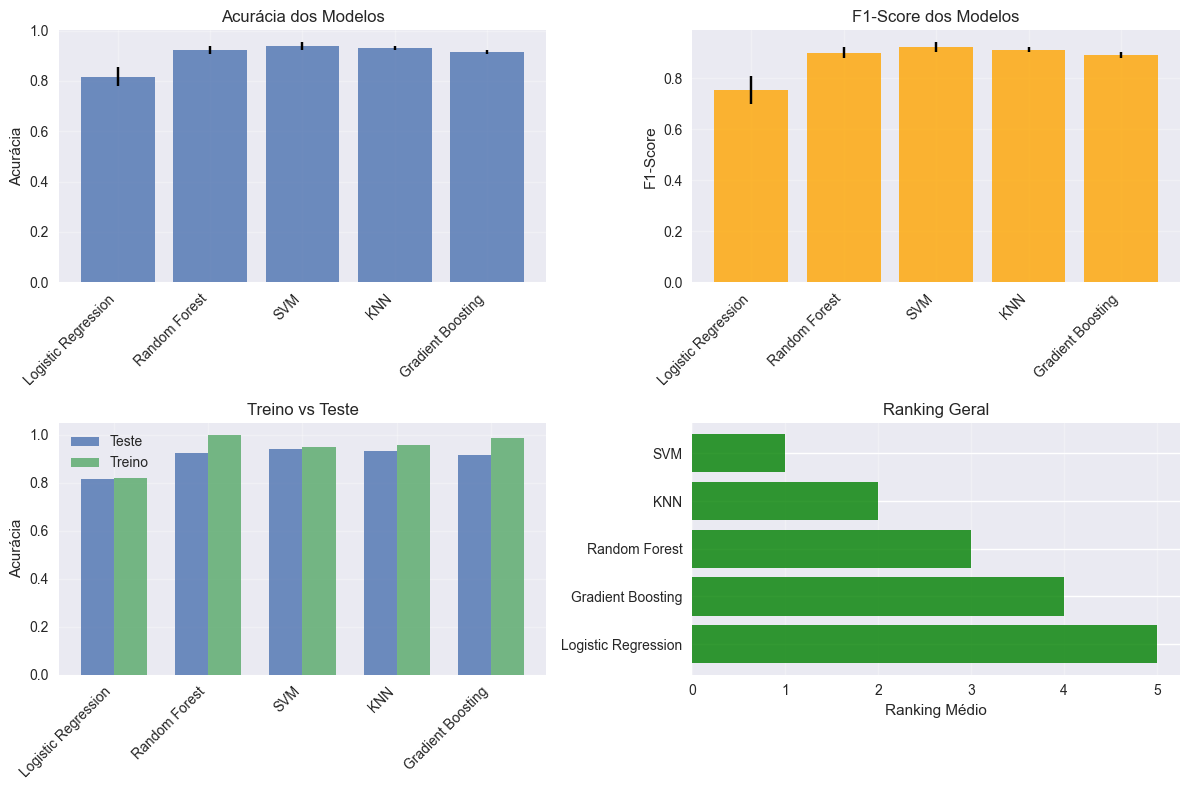

🏆 Melhor modelo: SVM
🎯 Melhor acurácia: SVM (0.9390)


In [11]:
# Visualização dos resultados
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Comparação de Accuracy
model_names = list(models.keys())
test_accuracies = [model_results[name]["test_accuracy"]["mean"] for name in model_names]
test_stds = [model_results[name]["test_accuracy"]["std"] for name in model_names]

axes[0, 0].bar(range(len(model_names)), test_accuracies, yerr=test_stds, capsize=5, alpha=0.8)
axes[0, 0].set_xticks(range(len(model_names)))
axes[0, 0].set_xticklabels(model_names, rotation=45, ha="right")
axes[0, 0].set_ylabel("Acurácia")
axes[0, 0].set_title("Acurácia dos Modelos")
axes[0, 0].grid(True, alpha=0.3)

# 2. F1-Score
test_f1 = [model_results[name]["test_f1"]["mean"] for name in model_names]
test_f1_stds = [model_results[name]["test_f1"]["std"] for name in model_names]

axes[0, 1].bar(range(len(model_names)), test_f1, yerr=test_f1_stds, capsize=5, alpha=0.8, color="orange")
axes[0, 1].set_xticks(range(len(model_names)))
axes[0, 1].set_xticklabels(model_names, rotation=45, ha="right")
axes[0, 1].set_ylabel("F1-Score")
axes[0, 1].set_title("F1-Score dos Modelos")
axes[0, 1].grid(True, alpha=0.3)

# 3. Treino vs Teste (Accuracy)
train_accuracies = [model_results[name]["train_accuracy"]["mean"] for name in model_names]
x_pos = np.arange(len(model_names))
width = 0.35

axes[1, 0].bar(x_pos - width / 2, test_accuracies, width, label="Teste", alpha=0.8)
axes[1, 0].bar(x_pos + width / 2, train_accuracies, width, label="Treino", alpha=0.8)
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(model_names, rotation=45, ha="right")
axes[1, 0].set_ylabel("Acurácia")
axes[1, 0].set_title("Treino vs Teste")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Ranking dos modelos
ranking_data = []
for model_name in model_names:
    avg_rank = 0
    for metric in ["accuracy", "f1"]:
        scores = [model_results[name][f"test_{metric}"]["mean"] for name in model_names]
        rank = sorted(scores, reverse=True).index(model_results[model_name][f"test_{metric}"]["mean"]) + 1
        avg_rank += rank
    avg_rank /= 2
    ranking_data.append((model_name, avg_rank))

ranking_data.sort(key=lambda x: x[1])
ranked_models = [item[0] for item in ranking_data]
ranks = [item[1] for item in ranking_data]

axes[1, 1].barh(range(len(ranked_models)), ranks, alpha=0.8, color="green")
axes[1, 1].set_yticks(range(len(ranked_models)))
axes[1, 1].set_yticklabels(ranked_models)
axes[1, 1].set_xlabel("Ranking Médio")
axes[1, 1].set_title("Ranking Geral")
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

# Resumo
print(f"🏆 Melhor modelo: {ranked_models[0]}")
best_acc = max(test_accuracies)
best_model = model_names[test_accuracies.index(best_acc)]
print(f"🎯 Melhor acurácia: {best_model} ({best_acc:.4f})")

## 7. Resumo e Boas Práticas

### Principais Conceitos

- **Cross-validation** fornece estimativas mais robustas que holdout validation
- **Stratified K-Fold** é essencial para classificação (mantém proporção das classes)
- **k=5 ou k=10** são escolhas padrão na literatura
- **LOOCV** é útil para datasets pequenos, mas computacionalmente caro

### Diretrizes Práticas

**Quando usar cada tipo:**

- **5-Fold CV**: Análise rápida, datasets grandes
- **10-Fold CV**: Padrão científico
- **Stratified K-Fold**: Sempre para classificação
- **LOOCV**: Datasets pequenos (< 1000 amostras)

**Cuidados importantes:**

- Sempre usar estratificação em classificação
- Fixar random_state para reprodutibilidade
- Analisar gap treino-teste para detectar overfitting
- Considerar custo computacional vs. precisão da estimativa
